# load data

In [1]:
# from os import listdir
# folder = "./"

In [2]:
# print(listdir("./"))

['.ipynb_checkpoints', 'Lab13-2_106062116.ipynb', 'spec_train_val.txt', 'words_captcha', 'words_captcha.zip', '__MACOSX']


In [3]:
# print(len(listdir(folder + "words_captcha/")))

140000


In [7]:
# import os
# import shutil

# os.rename(folder+"words_captcha/spec_train_val.txt", folder+"spec_train_val.txt")

(320, 600, 3)


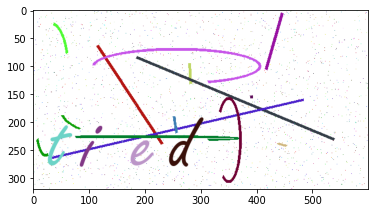

In [4]:
# import matplotlib.pyplot as plt
# import cv2 
  
# img = cv2.imread(folder+'words_captcha/a2.png')
# print(img.shape)
# plt.imshow(img)
# plt.show()

# generate dataset

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
import re
import numpy as np
import os
import time
import cv2

In [6]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [50]:
# Feel free to change these parameters according to your system's configuration
folder = "./"
max_length = 0
IMAGE_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = 0
num_steps = 100000 // BATCH_SIZE
top_k = 100
features_shape = 2048
attention_features_shape = 64
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token=None, filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [55]:
class DatasetGenerator:

    def __init__(self):
        global vocab_size, max_length
        self.img_name = []
        self.words = []
        f = open(folder+'spec_train_val.txt', 'r')
        lines = f.readlines() 
        for i, line in enumerate(lines):
            if i==100000:
                break
            tmp = line[:-1].split(" ")
            self.img_name.append(tmp[0])
            word_list = ['<start>']
            for ch in tmp[1]:
                word_list.append(ch)
            word_list.append('<end>')
            self.words.append(" ".join(word_list))

        tokenizer.fit_on_texts(self.words)
        tokenizer.word_index['<pad>'] = 0
        tokenizer.index_word[0] = '<pad>'
        
        vocab_size = len(tokenizer.word_index)
        print("vocab_size: ", vocab_size)
        print("index to words: ", tokenizer.index_word)
        self.words = tokenizer.texts_to_sequences(self.words)
        max_length = calc_max_length(self.words)
        # Pad each vector to the max_length of the captions
        # If you do not provide a max_length value, pad_sequences calculates it automatically
        self.words = tf.keras.preprocessing.sequence.pad_sequences(self.words, padding='post')
        


    def _data_preprocess(self, img_name, words):
        image_file = tf.io.read_file(folder + 'words_captcha/' + img_name + '.png')
        img = tf.io.decode_jpeg(image_file, channels=3)
        img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        img = tf.cast(img, tf.float32)
        img = img/255

        return img, words

    def generate(self):
        t_img_name, t_word = self.img_name[:100000], np.array(self.words[:100000])
        t_dataset = tf.data.Dataset.from_tensor_slices((t_img_name, t_word))
        t_dataset = t_dataset.shuffle(BUFFER_SIZE)
        t_dataset = t_dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        t_dataset = t_dataset.batch(BATCH_SIZE, drop_remainder=True)
        t_dataset = t_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return t_dataset

In [57]:
train_dataset = DatasetGenerator().generate()
print("max length: ", max_length)

vocab_size:  29
index to words:  {1: '<start>', 2: '<end>', 3: 'e', 4: 'a', 5: 's', 6: 'o', 7: 'i', 8: 't', 9: 'r', 10: 'l', 11: 'n', 12: 'd', 13: 'c', 14: 'p', 15: 'm', 16: 'u', 17: 'h', 18: 'g', 19: 'b', 20: 'y', 21: 'f', 22: 'k', 23: 'w', 24: 'v', 25: 'j', 26: 'x', 27: 'z', 28: 'q', 0: '<pad>'}
max length:  7


# feature extractor

In [33]:
def conv_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.RandomUniform())(inputs)
    x = layers.ReLU()(x)

    return x

In [58]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_relu(img_inputs, 16, 3, 1)
x = conv_relu(x, 16, 3, 1)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = conv_relu(x, 32, 3, 1)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = conv_relu(x, 32, 3, 1)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = conv_relu(x, 48, 3, 1)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.25)(x)
outputs = layers.Dense(500, kernel_initializer=tf.keras.initializers.RandomUniform(), activation='relu')(x)

extractor = keras.Model(inputs=img_inputs, outputs=outputs, name="ext")

In [59]:
extractor.summary()

Model: "ext"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0       

# CNN-RNN model

In [60]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
        
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [61]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [62]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# CKPT

In [63]:
checkpoint_path = folder + 'ckpt/'
ckpt = tf.train.Checkpoint(net=extractor, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [64]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

print("start epoch: ", start_epoch)

start epoch:  0


# Training

In [65]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [66]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:

        features = extractor(img_tensor)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = extractor.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss  

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Train Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Validation set accuracy

In [ ]:
def load_image(img_name):
    image_file = tf.io.read_file(folder + 'words_captcha/' + img_name + '.png')
    img = tf.io.decode_jpeg(image_file, channels=3)
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    img = tf.cast(img, tf.float32)
    img = img/255
    return img

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    features = extractor(temp_input)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
img_name_val = []
cap_val = []
f = open(folder + 'spec_train_val.txt', 'r')
lines = f.readlines() 

for i, line in enumerate(lines):
    if i<100000:
        continue
    tmp = line[:-1].split(" ")
    val_img_name.append(tmp[0])
    val_words.append(tmp[1])

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
img = cv2.imread(folder + 'words_captcha/' + image + '.png')
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
true_num = 0

for rid in range(len(val_words)):
    image = img_name_val[rid]
    real_caption = cap_val[rid]+'<end>'
    result, attention_plot = evaluate(image)
    predict_caption = ''.join(result)
    if real_caption == predict_caption:
        true_num += 1
    
print("validation accuracy: ", true_num / 20000)

In [ ]:
file1 = open("prediction.txt","w") 

for i in range(120000, 140000):
    image = 'a' + str(i)
    result, attention_plot = evaluate(image)
    predict_caption = ''.join(result)
    file1.write(predict_caption + '\n')
    
file1.close() 